## Image Classification using Convolutional Neural Networks 

In this example we will use Keras to build a deep Convolutional Neural Network (CNN) and train it on the STL-10 dataset.

After 100 training epochs, this network scores ~71% top-1 accuracy on the dataset's test-set.



### Preparations

First, lets import all the modules we use below.

In [1]:
import os
import urllib.request as urllib
import tarfile
import sys

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.engine.training import Model
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Input
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


Lets define a few constants we will later use

In [20]:
# the dimensions of each image in the STL-10 dataset (96x96x3).
HEIGHT, WIDTH, DEPTH = 96, 96, 3

# number of classes in the STL-10 dataset.
N_CLASSES = 10

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './stl10_data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
TRAIN_DATA_PATH = DATA_DIR + '/stl10_binary/train_X.bin'

# path to the binary test file with image data
TEST_DATA_PATH = DATA_DIR + '/stl10_binary/test_X.bin'

# path to the binary train file with labels
TRAIN_LABELS_PATH = DATA_DIR + '/stl10_binary/train_y.bin'

# path to the binary test file with labels
TEST_LABELS_PATH = DATA_DIR + '/stl10_binary/test_y.bin'

# path to class names file
CLASS_NAMES_PATH = DATA_DIR + '/stl10_binary/class_names.txt'


Next, we need to download and load the SLT-10 dataset. Lets write a few helper functions to do that.


In [3]:
def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, DEPTH, WIDTH, HEIGHT))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def download_and_extract():
    # if the dataset already exists locally, no need to download it again.
    if all((
        os.path.exists(TRAIN_DATA_PATH),
        os.path.exists(TRAIN_LABELS_PATH),
        os.path.exists(TEST_DATA_PATH),
        os.path.exists(TEST_LABELS_PATH),
    )):
        return

    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
        
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                                                          float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()

        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def load_dataset():
    # download the extract the dataset.
    download_and_extract()

    # load the train and test data and labels.
    x_train = read_all_images(TRAIN_DATA_PATH)
    y_train = read_labels(TRAIN_LABELS_PATH)
    x_test = read_all_images(TEST_DATA_PATH)
    y_test = read_labels(TEST_LABELS_PATH)

    # convert all images to floats in the range [0, 1]
    x_train = x_train.astype('float32')
    x_train = (x_train - 127.5) / 127.5
    x_test = x_test.astype('float32')
    x_test = (x_test - 127.5) / 127.5
    
    # convert the labels to be zero based.
    y_train -= 1
    y_test -= 1

    # convert labels to hot-one vectors.
    y_train = keras.utils.to_categorical(y_train, N_CLASSES)
    y_test = keras.utils.to_categorical(y_test, N_CLASSES)

    return (x_train, y_train), (x_test, y_test)


We can now load the dataset.


In [4]:
(x_train, y_train), (x_test, y_test) = load_dataset()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(5000, 96, 96, 3) (5000, 10) (8000, 96, 96, 3) (8000, 10)


Notice that we have 5000 images in our training set, and 8000 images in out test set. 
Each image is of dimension 96x96 and has three color channels (RGB).
Let's take a look at how these images look like:


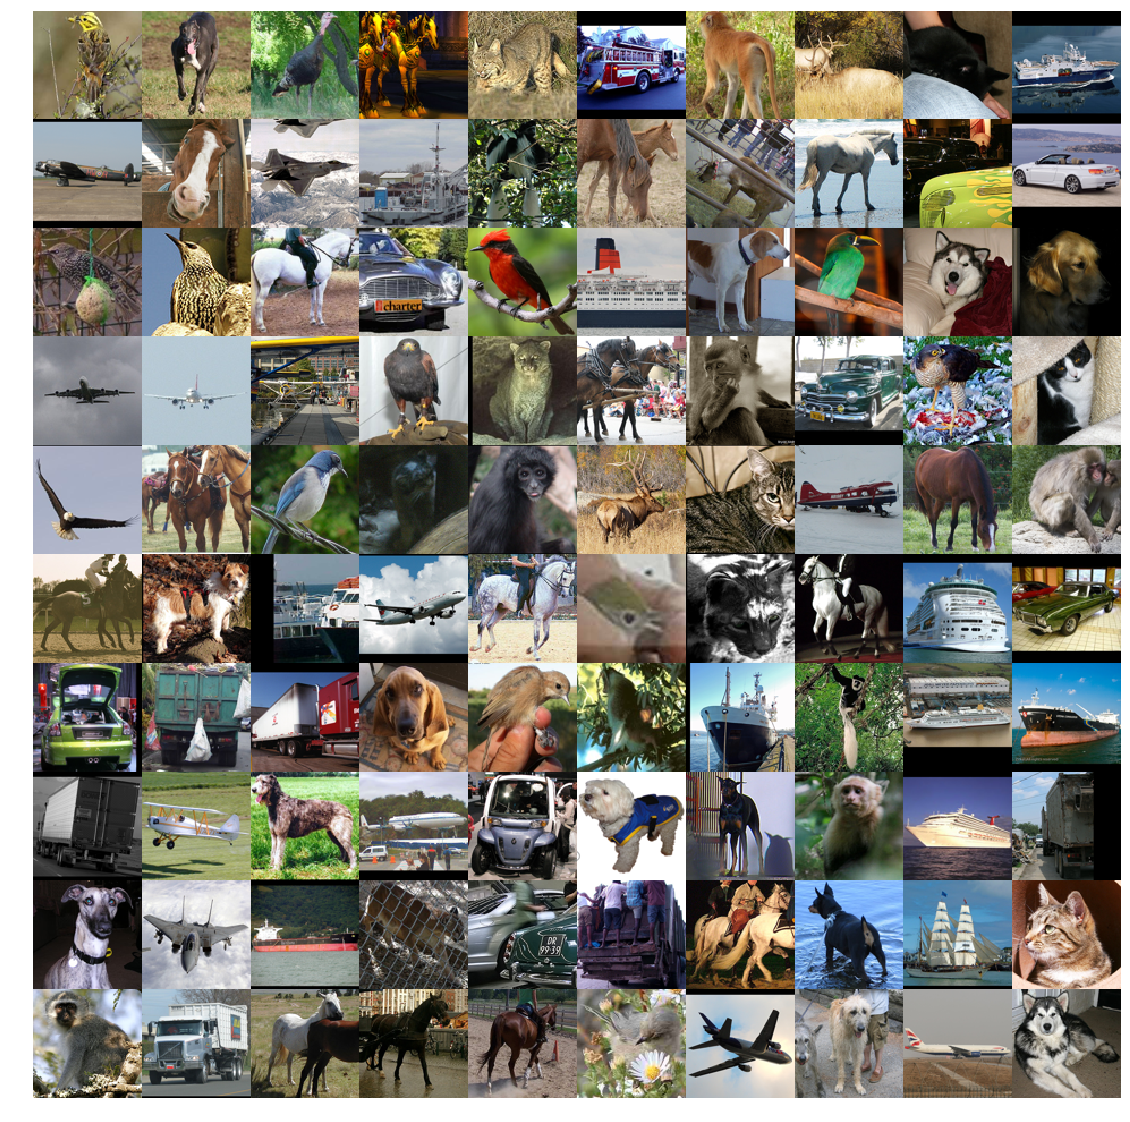

In [5]:
def plot_images(images, n_images):
    _, h, w, d = images.shape
    # create an array that will store the images to plot.
    canvas = np.empty((h * n_images, w * n_images, d), dtype='uint8')

    for i in range(n_images):
        img_column = images[i * n_images:(i + 1) * n_images]
        for j in range(n_images):
            if j >= img_column.shape[0]:
                break

            # transform images to the range [0, 255]
            img = img_column[j]
            img = ((img * 127.5) + 127.5).clip(0, 255).astype('uint8')            
            canvas[i * h:(i + 1) * h, j * w:(j + 1) * w] = img

    plt.figure(figsize=(2 * n_images, 2 * n_images))
    plt.axis('off')
    cmap = 'gray' if d == 1 else None
    plt.imshow(canvas.squeeze(), origin="upper", cmap=cmap)
    plt.show()


plot_images(x_train, 10)

Nice. 

### Building the Model

Next, lets build our CNN model. We will use the classic structure of multiple convolutional blocks, each consisting on two Convolutional layers, followed by a Max-Pooling layer and a Dropout layer. After the convolutional blocks, we will use two Fully-Connected layers to perform the final classification.  For non-linearities, we will use the ELU activation.

We will also add a Batch-Normalization layer to normalize the outputs of all other layers, this has mulitple advantages including regularization, and a significant training speedup (iterations-wise).


In [6]:
def build_classifier_model():
    n_conv_blocks = 5  # number of convolution blocks to have in our model.
    n_filters = 32  # number of filters to use in the first convolution block.
    l2_reg = regularizers.l2(2e-4)  # weight to use for L2 weight decay. 
    activation = 'elu'  # the activation function to use after each linear operation.

    if K.image_data_format() == 'channels_first':
        input_shape = (3, HEIGHT, WIDTH)
    else:
        input_shape = (HEIGHT, WIDTH, 3)

    x = input_1 = Input(shape=input_shape)
    
    # each convolution block consists of two sub-blocks of Conv->Batch-Normalization->Activation,
    # followed by a Max-Pooling and a Dropout layer.
    for i in range(n_conv_blocks):
        shortcut = Conv2D(filters=n_filters, kernel_size=(1, 1), padding='same', kernel_regularizer=l2_reg)(x)
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = Add()([shortcut, x])
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.25)(x)
        
        n_filters *= 2

    # finally, we flatten the output of the last convolution block, and add two Fully-Connected layers.
    x = Flatten()(x)
    x = Dense(units=512, kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation)(x)

    x = Dropout(rate=0.5)(x)
    x = Dense(units=N_CLASSES, kernel_regularizer=l2_reg)(x)
    output = Activation(activation='softmax')(x)

    return Model(inputs=[input_1], outputs=[output])


model = build_classifier_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

By calling the model's summary function, we get a nice printout of our network's structure, including the total number of trainable parameters (~7.2M trainable parameters in our case).

### Training the Model

Next, we will train our model on our training set. We will use mini-batches of 128 images, and a total of 100 epochs.
As an optimizer we will use Adam with an initial learning rate of 0.001. We will also use a learning-rate schedule in which the learning-rate will be reduced by a factor of two when reaching epochs 20, 40, 50, 60, 70, 80 and 90.
As a loss function we will use categorical cross-entropy, which suites our multi-class classification problem.

In [7]:
def train_classifier(model_output_path=None, batch_size=128, epochs=100, initial_lr=1e-3):    
    def lr_scheduler(epoch):
        if epoch < 20:
            return initial_lr
        elif epoch < 40:
            return initial_lr / 2
        elif epoch < 50:
            return initial_lr / 4
        elif epoch < 60:
            return initial_lr / 8
        elif epoch < 70:
            return initial_lr / 16
        elif epoch < 80:
            return initial_lr / 32
        elif epoch < 90:
            return initial_lr / 64
        else:
            return initial_lr / 128

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(initial_lr),
        metrics=['accuracy']
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(x_test, y_test),
        callbacks=[LearningRateScheduler(lr_scheduler)]
    )

    if model_output_path is not None:
        print('saving trained model to:', model_output_path)
        model.save(model_output_path)
        
    return history


history = train_classifier()


Train on 5000 samples, validate on 8000 samples
Epoch 1/100
 - 41s - loss: 2.8564 - acc: 0.3322 - val_loss: 8.8937 - val_acc: 0.2424
Epoch 2/100
 - 38s - loss: 2.3868 - acc: 0.4104 - val_loss: 6.2760 - val_acc: 0.2521
Epoch 3/100
 - 38s - loss: 2.1750 - acc: 0.4824 - val_loss: 4.2930 - val_acc: 0.3009
Epoch 4/100
 - 38s - loss: 2.1302 - acc: 0.4882 - val_loss: 2.8535 - val_acc: 0.3356
Epoch 5/100
 - 38s - loss: 2.0161 - acc: 0.5354 - val_loss: 2.5964 - val_acc: 0.3756
Epoch 6/100
 - 38s - loss: 1.8646 - acc: 0.5798 - val_loss: 3.2454 - val_acc: 0.3021
Epoch 7/100
 - 38s - loss: 1.7696 - acc: 0.6052 - val_loss: 2.7105 - val_acc: 0.4055
Epoch 8/100
 - 38s - loss: 1.6720 - acc: 0.6476 - val_loss: 2.3893 - val_acc: 0.4415
Epoch 9/100
 - 38s - loss: 1.6596 - acc: 0.6452 - val_loss: 2.3790 - val_acc: 0.4709
Epoch 10/100
 - 38s - loss: 1.5892 - acc: 0.6756 - val_loss: 2.0379 - val_acc: 0.5577
Epoch 11/100
 - 38s - loss: 1.4336 - acc: 0.7286 - val_loss: 1.8019 - val_acc: 0.6268
Epoch 12/100
 -

Epoch 96/100
 - 38s - loss: 0.4756 - acc: 0.9990 - val_loss: 1.6913 - val_acc: 0.7140
Epoch 97/100
 - 38s - loss: 0.4733 - acc: 0.9982 - val_loss: 1.6879 - val_acc: 0.7141
Epoch 98/100
 - 38s - loss: 0.4735 - acc: 0.9992 - val_loss: 1.6884 - val_acc: 0.7123
Epoch 99/100
 - 38s - loss: 0.4735 - acc: 0.9988 - val_loss: 1.6896 - val_acc: 0.7135
Epoch 100/100
 - 38s - loss: 0.4738 - acc: 0.9988 - val_loss: 1.6886 - val_acc: 0.7129


Let's plot our model's training loss and top-1 accuracy, as a function of the training epoch number.

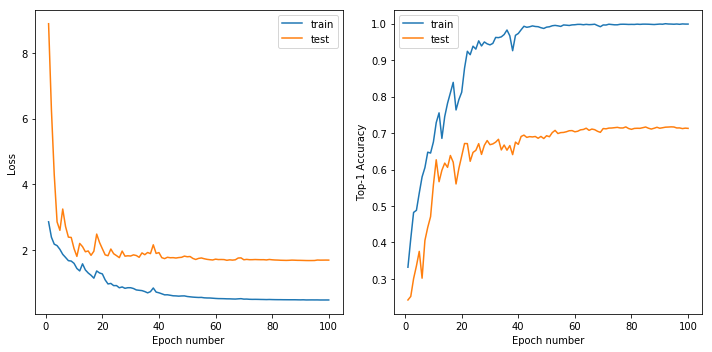

In [15]:
def plot_training_history(history):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].plot(np.arange(1, epochs + 1), loss, label='train')
    axs[0].plot(np.arange(1, epochs + 1), val_loss, label='test')
    axs[0].set_xlabel('Epoch number')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc="best")

    acc, val_acc = history.history['acc'], history.history['val_acc']
    axs[1].plot(np.arange(1, epochs + 1), acc, label='train')
    axs[1].plot(np.arange(1, epochs + 1), val_acc, label='test')
    axs[1].set_xlabel('Epoch number')
    axs[1].set_ylabel('Top-1 Accuracy')
    axs[1].legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    
    
plot_training_history(history)


### Evaluating the Model

First, let's evaluate our model on the train and test sets.

In [16]:
print('Train-set performance --> loss: {:.4f}, accuracy: {:.4f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print('Test-set performance --> loss: {:.4f}, accuracy: {:.4f}'.format(*model.evaluate(x_test, y_test, verbose=0)))

Train-set performance --> loss: 0.4643, accuracy: 1.0000
Test-set performance --> loss: 1.6886, accuracy: 0.7129


Finally, let's manual-test our trained model against an arbitrary image from the test set.

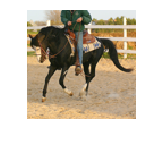

horse: 100.0%, dog: 0.0%, deer: 0.0%, cat: 0.0%, airplane: 0.0%


In [21]:
def load_label_names():
    # load the STL-10 class label names.
    with open(CLASS_NAMES_PATH, 'r') as f:
        return np.array([l.strip() for l in f])


label_names = load_label_names()


def get_prediction(x, top_n=5):
    # get the model's prediction on x.
    predictions = model.predict(x)[0]
    predictions *= 100
    
    # get the predictions sorted indices in reversed order.
    order = np.argsort(predictions)[::-1]
    
    # print the top_n predictions along with their class labels, in revered order.
    sorted_predictions = list(zip(label_names[order], predictions[order]))
    print(', '.join(['{}: {:.1f}%'.format(label, confidence) for label, confidence in sorted_predictions[:top_n]]))


img = x_test[0, np.newaxis]
plot_images(img, 1)
get_prediction(img)

And indeed, this is an image of a horse. Cool!

For more Keras examples, see my [GitHub repository](https://github.com/matanby/keras-examples)